In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys 
from banditopt.objectives import Resolution
from tqdm import tqdm, trange
sys.path.insert(0, "../")
from attribute_datasets import LowHighResolutionDataset, TubulinActinDataset

    

In [ ]:
dataset = TubulinActinDataset(
    
)

### Resolution experiment

In [56]:
dataset = LowHighResolutionDataset(
    h5path=f"/home-local/Frederic/evaluation-data/low-high-quality/training.hdf5",
    num_samples=None,
    transform=None,
    n_channels=1,
    num_classes=2,
    classes=["low", "high"] 
)

def compute_resolution(img: np.ndarray) -> float:
    if img.shape[0] == 3:
        img = img[0]
    resolution_objective = Resolution(pixelsize=20e-9)
    resolution = resolution_objective.evaluate([img], None, None, None, None)
    return resolution

scores, labels = [], []
for i in trange(len(dataset)):
    img, metadata =  dataset[i]
    img = img.squeeze().numpy()
    resolution = compute_resolution(img)
    # print(metadata["label"], resolution)
    scores.append(resolution)
    labels.append(metadata["label"])

scores = np.array(scores)
labels = np.array(labels)

thresholds = np.linspace(scores.min(), scores.max(), 1000)
accuracies = [] 
for threshold in tqdm(thresholds):
    pred_labels = (scores < threshold).astype(int)
    accuracy = np.sum(pred_labels == labels) / len(labels)
    accuracies.append(accuracy)


resolution_threshold = thresholds[np.argmax(accuracies)]
print(f"Best threshold: {best_threshold}")
print(f"Best accuracy: {np.max(accuracies)}")
quality_threshold = 0.70


  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 120308.18it/s]

Best threshold: 105.0442312663354
Best accuracy: 0.9175257731958762


In [70]:
def load_data(path: str):
    data = np.load(path)
    return data 

def plot_all_resolution_trajectories(data: np.ndarray, threshold: float):
    y = data["all_resolutions"]
    x = data["all_distances"]
    tp, tn, fp, fn = 0, 0, 0, 0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(y.shape[0]):
        ax.plot(x[i], y[i], color="grey", alpha=0.5)
        for j in range(y[i].shape[0]):
            res, dis = y[i][j], x[i][j]
            if res < threshold:
                if dis < 0.0:
                    fp += 1
                elif dis > 0.0:
                    tp += 1
            else:
                if dis < 0.0:
                    tn += 1
                elif dis > 0.0:
                    fn += 1
            color = "dodgerblue" if res < threshold else "fuchsia"
            ax.scatter(dis, res, color=color)
    ax.axhline(threshold, color="black", linestyle="--")
    ax.axvline(0.0, color="black", linestyle="-")
    ax.set_xlabel("Distance to boundary")
    ax.set_ylabel("Resolution")
    fig.savefig(f"../resolution-experiment/MAE_SMALL_STED-all_resolution_trajectories.pdf", bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return tp, tn, fp, fn

def plot_all_quality_trajectories(data: np.ndarray, threshold: float):
    y = data["all_scores"]
    x = data["all_distances"]
    tp, tn, fp, fn = 0, 0, 0, 0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(y.shape[0]):
        ax.plot(x[i], y[i], color="grey", alpha=0.5)
        for j in range(y[i].shape[0]):
            res, dis = y[i][j], x[i][j]
            if res > threshold:
                if dis < 0.0:
                    fp += 1
                elif dis > 0.0:
                    tp += 1
            else:
                if dis < 0.0:
                    tn += 1
                elif dis > 0.0:
                    fn += 1
            color = "dodgerblue" if res > threshold else "fuchsia"
            ax.scatter(dis, res, color=color)
    ax.axhline(threshold, color="black", linestyle="--")
    ax.axvline(0.0, color="black", linestyle="-")
    ax.set_xlabel("Distance to boundary")
    ax.set_ylabel("Quality")
    fig.savefig(f"../quality-experiment/MAE_SMALL_STED-all_quality_trajectories.pdf", bbox_inches="tight")
    plt.show()
    plt.close(fig)
    return tp, tn, fp, fn
    
    

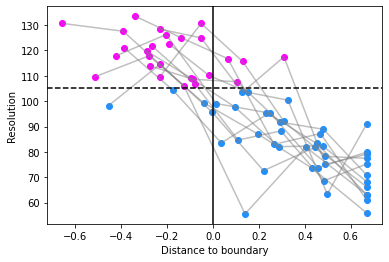

TP: 41
TN: 23
FP: 4
FN: 4
Recall: 0.9111111111111111
Precision: 0.9111111111111111
F1 score: 0.9111111111111111


In [71]:
data = load_data(f"../resolution-experiment/correlation/MAE_SMALL_STED-resolution-correlation.npz")
tp, tn, fp, fn = plot_all_resolution_trajectories(data, threshold=resolution_threshold)

def get_precision(tp, fp):
    return tp / (tp + fp)

def get_recall(tp, fn):
    return tp / (tp + fn)

def get_f1_score(tp, fp, fn):
    return 2 * tp / (2 * tp + fp + fn)

recall = get_recall(tp, fn)
precision = get_precision(tp, fp)
f1_score = get_f1_score(tp, fp, fn)

print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1_score}")

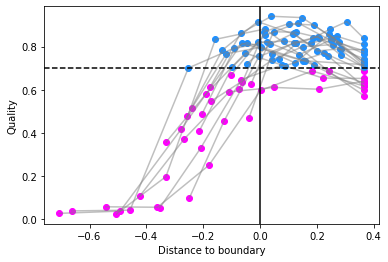

TP: 61
TN: 31
FP: 14
FN: 14
Recall: 0.8133333333333334
Precision: 0.8133333333333334
F1 score: 0.8133333333333334


In [72]:
data = load_data(f"../quality-experiment/correlation/MAE_SMALL_STED-quality-correlation.npz")
tp, tn, fp, fn = plot_all_quality_trajectories(data, threshold=quality_threshold)
recall = get_recall(tp, fn)
precision = get_precision(tp, fp)
f1_score = get_f1_score(tp, fp, fn)

print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 score: {f1_score}")
